# Marine ecosystem modelling

> Author: Victor Boussange
> 
> Email: vic.boussange@gmail.com

We'll generate synthetic data from a 5 species marine ecosystem model, and save the data.

In [1]:
cd(@__DIR__)
using Pkg; Pkg.activate(".")
using Graphs
using EcoEvoModelZoo
using ParametricModels
using LinearAlgebra
using UnPack
using OrdinaryDiffEq
using Statistics
using SparseArrays
using ComponentArrays
using PythonPlot

  Activating project at `~/ETHZ/projects/MyTutorials/PiecewiseInference`


### Defining hyperparameters for the forward simulation of the model.


### Defining the foodweb structure

In the model considered, we have
1. Phytoplankton
2. Zooplankton
3. Small prey fishes
4. Small predators
5. Large predators

Each of those will correspond to a node in the `foodweb` graph. We add an edge between the node when there is a feeding interaction.

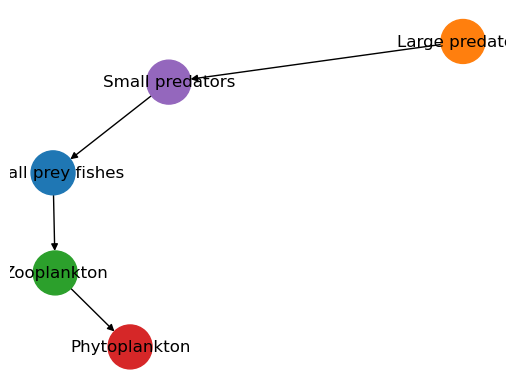

(<py Figure size 640x480 with 1 Axes>, <py Axes: >)

In [2]:
const N = 5 # number of compartment
node_labels = ["Phytoplankton", 
                "Zooplankton", 
                "Small prey fishes", 
                "Small predators", 
                "Large predators"]

foodweb = DiGraph(N)
[add_edge!(foodweb, i + 1 => i) for i in 1:4]

# plotting the foodweb
using PythonCall
nx = pyimport("networkx")
np = pyimport("numpy")
species_colors = ["tab:red", "tab:green", "tab:blue", "tab:purple", "tab:orange"]
function plot_foodweb(foodweb, pos, labs)
    g_nx = nx.DiGraph(np.array(adjacency_matrix(foodweb)))

    # shifting indices
    !isnothing(pos) && (pos = Dict(keys(pos) .- 1 .=> values(pos)))
    labs = Dict(keys(labs) .- 1 .=> values(labs))

    fig, ax = subplots(1)
    nx.draw(g_nx, pos, ax=ax, node_color=species_colors, node_size=1000, labels=labs)
    ax.set_facecolor("none")
    fig.set_facecolor("none")
    display(fig)
    return fig, ax
end
plot_foodweb(foodweb, nothing, node_labels)

We implement the processes. We use `Float32`, as these are less memory demanding than default `Float64`.

In [3]:
mytype = Float32

intinsic_growth_rate(p, t) = p.r

# only phytoplanktons have a carrying capacity
function carrying_capacity(p, t)
    @unpack K₁₁ = p
    K = vcat(K₁₁, ones(mytype, N - 1))
    return K
end

# only phytoplanktons have intraspecific competition
function competition(u, p, t)
    @unpack A₁₁ = p
    A = spdiagm(vcat(A₁₁, zeros(mytype, N-1)))
    return A * u
end

resource_conversion_efficiency(p, t) = ones(mytype, N)

using SparseArrays
W = adjacency_matrix(foodweb, mytype)
I, J, _ = findnz(W)

function feeding(u, p, t)
    @unpack H, q = p

    # handling time
    H_sp = sparse(I, J, H, N, N)

    # attack rates
    q_sp = sparse(I, J, q, N, N)

    return q_sp .* W ./ (one(eltype(u)) .+ q_sp .* H_sp .* (W * u))
end

feeding (generic function with 1 method)

In [4]:
# plotting
using PythonPlot;
function plot_time_series(data)
    fig, ax = subplots()
    for i in 1:N
        ax.plot(tsteps,data[i, :], label = node_labels[i], color = species_colors[i])
    end
    # ax.set_yscale("log")
    ax.set_ylabel("Species abundance")
    ax.set_xlabel("Time (days)")
    fig.set_facecolor("None")
    ax.set_facecolor("None")
    fig.legend()
    return fig
end

plot_time_series (generic function with 1 method)

In [5]:
tsteps = range(300f0, 1000f0, length=300)
hyper_params = (alg = BS3(),
                abstol = 1e-6,
                reltol = 1e-6,
                tspan = (0f0, tsteps[end]),
                saveat = tsteps,
                maxiters=50_000,)

(alg = BS3(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false)), abstol = 1.0e-6, reltol = 1.0e-6, tspan = (0.0f0, 1000.0f0), saveat = 300.0f0:2.3411372f0:1000.0f0, maxiters = 50000)

Below, we define the numerical values of the ecosystem model. Those values are arbitrary, but the order of magnitude matters:

- The handling time and attack rate for a given predator-prey interaction can vary widely depending on a number of factors, such as the predator and prey species involved, the size and life stage of the individuals, and the environmental conditions. However, here are some general ranges of handling times and attack rates for the types of organisms you mentioned: 
1. Phytoplankton:
Handling time: very short, usually less than a second
Attack rate: varies widely depending on the type of phytoplankton and the grazer species, but can range from less than 0.01 to several hundred grazed cells per grazer per hour. 
2. Zooplankton:
Handling time: typically a few seconds to minutes, depending on the size of the zooplankton and the type of prey.
Attack rate: varies widely depending on the type of zooplankton and the prey, but can range from a few prey items per hour to several hundred. 
3. Small prey fishes:
Handling time: typically a few seconds to minutes, depending on the size and type of prey fish and the predator species.
Attack rate: varies widely depending on the predator species and the prey fish species, but can range from a few prey items per hour to tens or hundreds. 
4. Small predators:
Handling time: typically a few minutes to hours, depending on the predator size and the prey size and type.
Attack rate: varies widely depending on the predator and prey species, but can range from a few prey items per day to dozens or more. 
5. Large predators:
Handling time: typically several hours to days, depending on the predator size and the size and type of prey.
Attack rate: generally lower than for smaller predators due to their larger size and energy requirements, and can range from a few prey items per week to several per day.

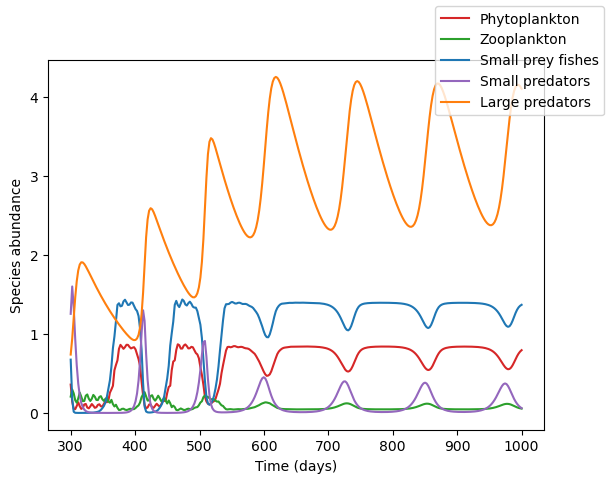

In [6]:
p_true = ComponentArray(H = [1f-1, 1f0, 2f0, 2f0], # handling time of [zoo, small prey, small predator, large predators]
                        q = [5f0, 2f0, 1f0, 1f-1],
                        r = [1f0, -0.4f0, -0.08f0, -0.05f0, -0.01f0],
                        K₁₁ = [1f0],
                        A₁₁ = [1f0])

u0_true = mytype[0.77, 0.10, 0.945, 0.1, 0.1]

mp = ModelParams(; p=p_true,
    u0=u0_true,
    hyper_params...)
model = SimpleEcosystemModel(; mp, intinsic_growth_rate,
    carrying_capacity,
    competition,
    resource_conversion_efficiency,
    feeding)

data = simulate(model, u0=u0_true) |> Array;

plot_time_series(data)

In [7]:
using CSV, DataFrames
df = DataFrame(hcat(tsteps, data'), vcat("Time stamp", node_labels))
CSV.write("marine_ecosystem.csv", df)

"marine_ecosystem.csv"